# Parallel Coordinates Plots

##### source: https://reedgroup.github.io/FigureLibrary/ParallelCoordinatesPlots.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

In [2]:
figsize = (18,6)
fontsize = 14
main_data_dir = "../output/metrics/"
data_dir_knobs = "../data/parallelplots/"
fig_dir = '../output/parallelplots/'

##### Functions for flexible parallel coordinates plots

In [3]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    ### if min/max directions not given for each axis, assume all should be maximized
    if minmaxs is None:
        minmaxs = ['max']*len(columns_axes)

    ### get subset of dataframe columns that will be shown as parallel axes
    objs_reorg = objs[columns_axes]

    ### reorganize & normalize data to go from 0 (bottom of figure) to 1 (top of figure), 
    ### based on direction of preference for figure and individual axes
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / \
                                         (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))

    return objs_reorg, tops, bottoms

In [4]:
### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous,
              color_by_categorical, color_dict_categorical):
    if color_by_continuous is not None:
        color = plt.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color

In [5]:
### function to get zorder value for ordering lines on plot. 
### This works by binning a given axis' values and mapping to discrete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    xgrid = np.arange(0, 1.001, 1/zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)

In [6]:
### customizable parallel coordinates plot
## COLUMN AXES???
def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None, color_palette_categorical=None, colorbar_ticks_continuous=None, color_dict_categorical=None, zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6), save_fig_filename=None):
    """
    Parameters:
    objs (DataFrame): The DataFrame containing the data to plot.
    columns_axes (list, optional): List of column names to use as axes. Defaults to all columns.
    axis_labels (list, optional): List of axis labels. Defaults to the same as columns_axes.
    ideal_direction (str, optional): Direction of preference for objective values. Can be 'top' or 'bottom'. Defaults to 'top'.
    minmaxs (list, optional): List of 'max' or 'min' for each column, indicating if higher or lower values are better.
    color_by_continuous (str, optional): Column name to color lines by continuous values. Cannot be used with color_by_categorical.
    color_palette_continuous (Colormap, optional): Colormap to use for continuous coloring.
    color_by_categorical (str, optional): Column name to color lines by categorical values. Cannot be used with color_by_continuous.
    color_palette_categorical (list, optional): List of colors to use for categorical coloring.
    colorbar_ticks_continuous (list, optional): List of tick values for the continuous colorbar.
    color_dict_categorical (dict, optional): Dictionary mapping categorical values to colors.
    zorder_by (str, optional): Column name to determine the z-order (layer) of the lines.
    zorder_num_classes (int, optional): Number of classes for z-ordering. Defaults to 10.
    zorder_direction (str, optional): Direction for z-ordering. Can be 'ascending' or 'descending'. Defaults to 'ascending'.
    alpha_base (float, optional): Base alpha (transparency) value for the lines. Defaults to 0.8.
    brushing_dict (dict, optional): Dictionary specifying brushing criteria in the form {column_index: (threshold, operator)}.
    alpha_brush (float, optional): Alpha value for lines that do not meet brushing criteria. Defaults to 0.05.
    lw_base (float, optional): Baseline width for the lines. Defaults to 1.5.
    fontsize (int, optional): Font size for the labels and annotations. Defaults to 14.
    figsize (tuple, optional): Size of the figure in inches. Defaults to (11, 6).
    save_fig_filename (str, optional): Filename to save the figure. If None, the figure is not saved. Defaults to None.
    """

    ### verify that all inputs take supported values
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        #axis_labels = columns_axes ## <--- column_axes is not defined? Ask about this (Axis labels have to be defined)
        axis_labels = columns_axes

    ### create figure
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})

    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)

            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)

            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i],
                              color_by_continuous, color_palette_continuous,
                              color_by_categorical, color_dict_categorical)

        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i],
                                zorder_num_classes, zorder_direction)

        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = alpha_brush
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base

        ## loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom',
                    zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top',
                        zorder=5, fontsize=fontsize)

        ax.plot([j,j], [0,1], c='k', zorder=1)

    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center',
                rotation=90, fontsize=fontsize)

    #ax.set_xlim(-0.4, 4.2) # REASON WHY ONLY 5 VARS
    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4,1.1)

    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)


    ### colorbar for continuous legend
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
        ### categorical legend
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3,
                              alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center',
                      ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)

    ### save figure
    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

In [222]:
def custom_parallel_coordinates_highlight_cluster(objs, columns_axes=None, axis_labels=None, ideal_direction='top', minmaxs=None, color_by_continuous=None, color_palette_continuous=None, color_by_categorical=None, color_palette_categorical=None, colorbar_ticks_continuous=None, color_dict_categorical=None, zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, lw_base=1.5, fontsize=14, figsize=(11,6), save_fig_filename=None, cluster_column_name='Cluster', title=None, highlight_indices=None, highlight_colors=None):
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = columns_axes

    fig, ax = plt.subplots(1, 1, figsize=figsize, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:, col_idx] >= threshold)

            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            rect = Rectangle([col_idx - 0.05, 0], 0.1, threshold_norm)
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)

    # Ensure baseline and highlight colors and labels
    baseline_present = 0 in objs.index
    highlight_labels = [f"median {i+1}" for i in range(len(highlight_indices))]
    highlight_colors = highlight_colors

    if baseline_present:
        highlight_indices = [0] + highlight_indices
        highlight_labels = ["baseline"] + highlight_labels
        highlight_colors = ["black"] + highlight_colors

    for i in range(objs_reorg.shape[0]):
        idx_value = objs.index[i]
        if idx_value == 0 and baseline_present:
            color = "black"
            zorder = 20  # Bring to the very front
            lw = 4  # Make line wider
            label = "baseline"
        elif idx_value in highlight_indices:
            color = highlight_colors[highlight_indices.index(idx_value)]
            zorder = 15  # Bring to the front
            lw = 4  # Make line wider
            label = highlight_labels[highlight_indices.index(idx_value)]
        elif color_by_categorical is not None and cluster_column_name in objs.columns:
            cluster_value = objs[cluster_column_name].iloc[i]
            color = color_dict_categorical.get(cluster_value, 'grey')  # Use color_dict_categorical for color
            zorder = 4
            lw = lw_base
            label = None
        else:
            color = color_dict_categorical[1]  # Fallback color if no cluster info
            zorder = 4
            lw = lw_base
            label = None

        alpha = alpha_base

        for j in range(objs_reorg.shape[1] - 1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j + 1]]
            x = [j, j + 1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)

    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
        ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)
        ax.plot([j, j], [0, 1], c='k', zorder=1)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15, 0.1, 0, 0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15, 0.9, 0, -0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3, 0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

    ax.set_xlim(-0.4, len(columns_axes) - 0.6)
    ax.set_ylim(-0.4, 1.1)

    for i, l in enumerate(axis_labels):
        ax.annotate(l, xy=(i, -0.12), ha='center', va='top', fontsize=fontsize)

    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(),
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4,
                          label=axis_labels[color_by_continuous], pad=0.03,
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous,
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)
    elif color_by_categorical is not None or highlight_indices is not None:
        leg = []
        if color_by_categorical is not None:
            for label, color in color_dict_categorical.items():
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))
        if highlight_indices is not None:
            for idx, color, label in zip(highlight_indices, highlight_colors, highlight_labels):
                leg.append(Line2D([0], [0], color=color, lw=3, alpha=alpha_base, label=label))

        _ = ax.legend(handles=leg, loc='lower center', ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5, -0.07], frameon=False, fontsize=fontsize)

    if title is not None:
        ax.set_title(title, fontsize=fontsize)

    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', transparent=True, dpi=600)

In [238]:
median_colors = ["#DC143C", "#FF8C00", "#4169E1"]
#median_colors = ["green", "pink", "purple"]
color_dict_categorical = {1: 'firebrick', 2: 'goldenrod', 3: 'cornflowerblue'}
color_dict_categorical_1 = {1: 'firebrick'}
color_dict_categorical_2 = {1: 'goldenrod'}
color_dict_categorical_3 = {1: 'cornflowerblue'}

### Kmedoid - July 16 Data
##### Note: Using the 12 variables with clusters generated from kmedoids for the previous 7 filtered variables

In [8]:
# df_clusters = pd.read_csv(data_dir_knobs + "filtered_metrics_07_01_2024_catknobs_idx3.csv")['Cluster']
# wet_df_clusters = pd.read_csv(data_dir_knobs + "filtered_wet_metrics_07_01_2024_catknobs_idx3.csv")['Cluster']
# dry_df_clusters = pd.read_csv(data_dir_knobs + "filtered_dry_metrics_07_01_2024_catknobs_idx3.csv")['Cluster']

In [71]:
df_clusters_new = pd.read_csv(data_dir_knobs + "filtered_metrics_07_01_2024_catknobs_KmedIdx3.csv")['Cluster']
wet_df_clusters_new = pd.read_csv(data_dir_knobs + "filtered_wet_metrics_07_01_2024_catknobs_KmedIdx3.csv")['Cluster']
dry_df_clusters_new = pd.read_csv(data_dir_knobs + "filtered_dry_metrics_07_01_2024_catknobs_KmedIdx3.csv")['Cluster']

In [115]:
df_716 = pd.read_csv(main_data_dir + "filtered_metrics_07_16_2024.csv").drop(["Unnamed: 0", "Ann_Avg_CVPAgUnmet"], axis = 1).iloc[:, 6:]
wet_df_716 = pd.read_csv(main_data_dir + "filtered_wet_metrics_07_16_2024.csv").drop(["Unnamed: 0"], axis = 1).iloc[:, 6:]
dry_df_716 = pd.read_csv(main_data_dir + "filtered_dry_metrics_07_16_2024.csv").drop(["Unnamed: 0"], axis = 1).iloc[:, 6:]

In [116]:
dry_df_716["Dry_Equity"] = pd.read_csv(data_dir_knobs + "20240605DRAFT_summary_metrics_dry.csv")["Equity"]
wet_df_716["Wet_Equity"] = pd.read_csv(data_dir_knobs + "20240605DRAFT_summary_metrics_wet.csv")["Equity"]

In [117]:
df_716["Cluster"] = df_clusters_new
dry_df_716["Cluster"] = dry_df_clusters_new
wet_df_716["Cluster"] = wet_df_clusters_new

In [118]:
# df_716.to_csv("df_07_16_24.csv", index = False)
# wet_df_716.to_csv("wet_df_07_16_24.csv", index = False)
# dry_df_716.to_csv("dry_df_07_16_24.csv", index = False)

In [119]:
df_716_g1 = df_716[["Ann_Avg_SWPTotDel_TAF", "Ann_Avg_SWPMIDel_TAF", "Ann_Avg_CVPTotDel_TAF", "Ann_Avg_CVPAgDel_TAF", "Ann_Avg_CVPSCEXDel_TAF", "Ann_Avg_BanksJones_TAF", "Cluster"]]
df_716_g2 = df_716[["Apr_Avg_ShstaStorage_TAF", "Apr_Avg_OrovlStorage_TAF", "Fall_Avg_X2_KM", "Spring_Avg_X2_KM", "Ann_Avg_NDO_TAF", "Equity", "Cluster"]]

In [120]:
wet_716_g1 = wet_df_716[["Wet_Ann_Avg_SWPTotDel_TAF", "Wet_Ann_Avg_SWPMIDel_TAF", "Wet_Ann_Avg_CVPTotDel_TAF", "Wet_Ann_Avg_CVPAgDel_TAF", "Wet_Ann_Avg_CVPSCEXDel_TAF", "Wet_Ann_Avg_BanksJones_TAF", "Cluster"]]

wet_716_g2 = wet_df_716[["Wet_Apr_Avg_ShstaStorage_TAF", "Wet_Apr_Avg_OrovlStorage_TAF", "Wet_Fall_Avg_X2_KM", "Wet_Spring_Avg_X2_KM", "Wet_Ann_Avg_NDO_TAF", "Wet_Equity", "Cluster"]]

In [121]:
dry_716_g1 = dry_df_716[["Dry_Ann_Avg_SWPTotDel_TAF", "Dry_Ann_Avg_SWPMIDel_TAF", "Dry_Ann_Avg_CVPTotDel_TAF", "Dry_Ann_Avg_CVPAgDel_TAF", "Dry_Ann_Avg_CVPSCEXDel_TAF", "Dry_Ann_Avg_BanksJones_TAF", "Cluster"]]

dry_716_g2 = dry_df_716[["Dry_Apr_Avg_ShstaStorage_TAF", "Dry_Apr_Avg_OrovlStorage_TAF", "Dry_Fall_Avg_X2_KM", "Dry_Spring_Avg_X2_KM", "Dry_Ann_Avg_NDO_TAF", "Dry_Equity", "Cluster"]]

In [122]:
df_716_g1.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
wet_716_g1.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]
dry_716_g1.columns = ["SWPTotDel", "SWPMIDel", "CVPTotDel", "CVPAgDel", "CVPSCEXDel", "BanksJones", "Cluster"]

df_716_g2.columns = ["ShastaStorage", "OrovilleStorage", "FallX2", "SpringX2", "NDO", "Equity", "Cluster"]
wet_716_g2.columns = ["ShastaStorage", "OrovilleStorage", "FallX2", "SpringX2", "NDO", "Equity", "Cluster"]
dry_716_g2.columns = ["ShastaStorage", "OrovilleStorage", "FallX2", "SpringX2", "NDO", "Equity", "Cluster"]

In [123]:
df_knobs = pd.read_csv(data_dir_knobs + "AllMedoidsStudyKnobs.csv")
wet_knobs = pd.read_csv(data_dir_knobs + "WetMedoidsStudyKnobs.csv")
dry_knobs = pd.read_csv(data_dir_knobs + "DryMedoidsStudyKnobs.csv")

In [124]:
all_medoids = df_knobs["Study"].tolist()
wet_medoids = wet_knobs["Study"].tolist()
dry_medoids = dry_knobs["Study"].tolist()

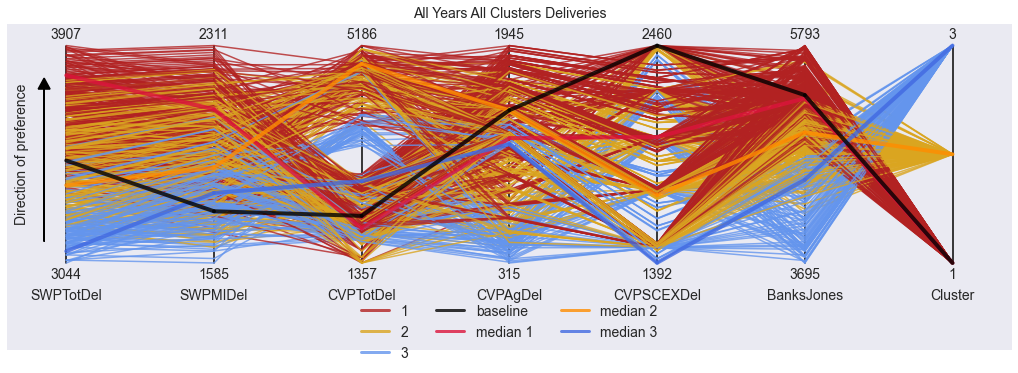

In [245]:
custom_parallel_coordinates_highlight_cluster(df_716_g1, columns_axes=df_716_g1.columns,
                                              axis_labels = df_716_g1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
                                              save_fig_filename = f'{fig_dir}/df_all_deliveries.png', title="All Years All Clusters Deliveries", highlight_indices = all_medoids, highlight_colors = median_colors) 

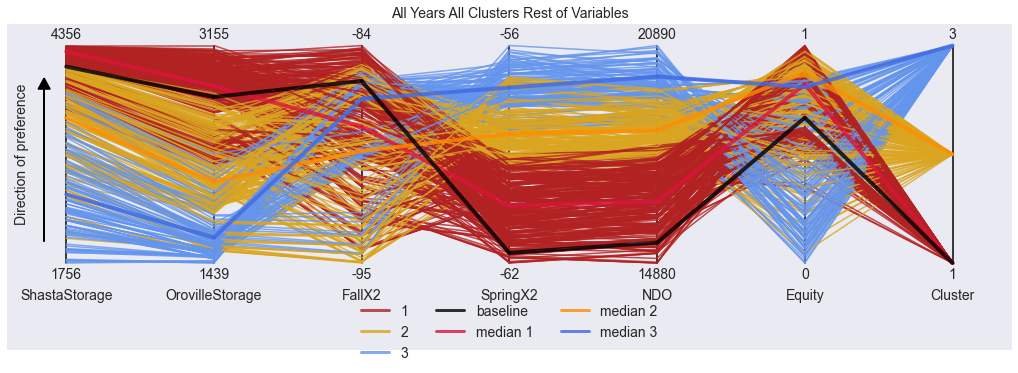

In [224]:
custom_parallel_coordinates_highlight_cluster(df_716_g2, columns_axes=df_716_g2.columns,
                                              axis_labels = df_716_g2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
                                              save_fig_filename = f'{fig_dir}/df_all_rest.png', title="All Years All Clusters Rest of Variables",
                                              highlight_indices = all_medoids, highlight_colors = median_colors)

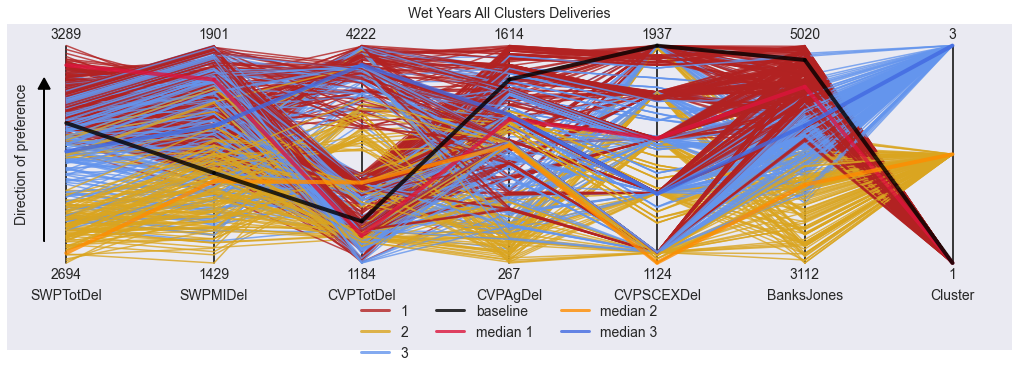

In [225]:
custom_parallel_coordinates_highlight_cluster(wet_716_g1, columns_axes=wet_716_g1.columns,
                                                axis_labels = wet_716_g1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max','max','max','max','max', 'max', 'max'],
                                                color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
                                                save_fig_filename = f'{fig_dir}/df_wet_deliveries.png', title="Wet Years All Clusters Deliveries", 
                                                highlight_indices = wet_medoids, highlight_colors = median_colors)

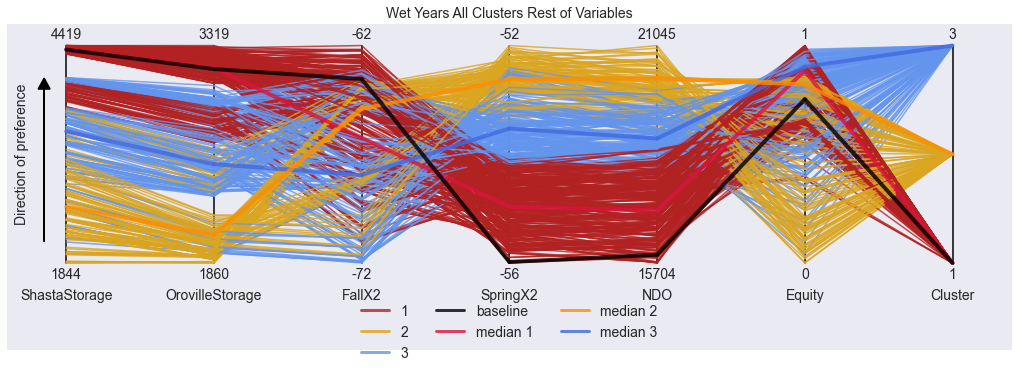

In [226]:
custom_parallel_coordinates_highlight_cluster(wet_716_g2, columns_axes=wet_716_g2.columns,
                                                axis_labels = wet_716_g2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max','max','max','max','max', 'max', 'max'],
                                                color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
                                                save_fig_filename = f'{fig_dir}/df_wet_rest.png', title="Wet Years All Clusters Rest of Variables", 
                                                highlight_indices = wet_medoids, highlight_colors = median_colors)

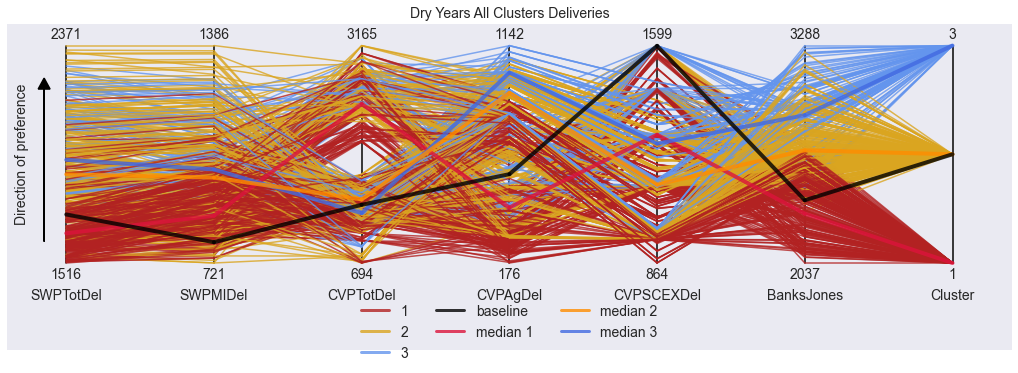

In [227]:
custom_parallel_coordinates_highlight_cluster(dry_716_g1, columns_axes=dry_716_g1.columns,
                                                axis_labels = dry_716_g1.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max','max','max','max','max', 'max', 'max'],
                                                color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
                                                save_fig_filename = f'{fig_dir}/df_dry_deliveries.png', title="Dry Years All Clusters Deliveries", 
                                                highlight_indices = dry_medoids, highlight_colors = median_colors)

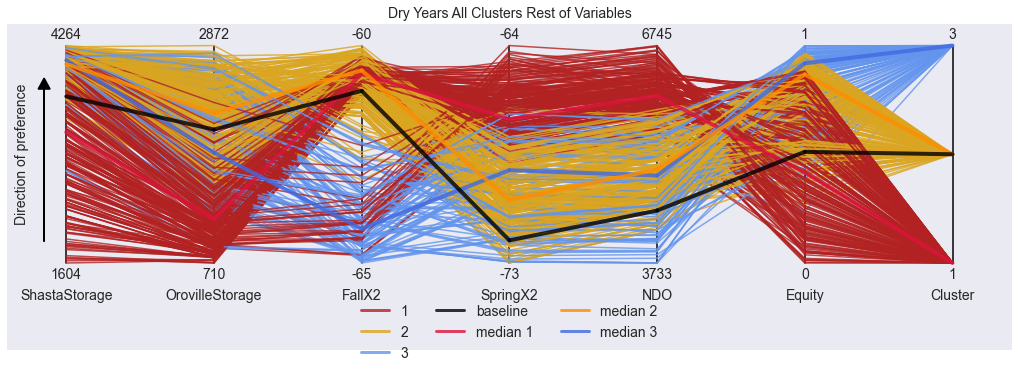

In [228]:
custom_parallel_coordinates_highlight_cluster(dry_716_g2, columns_axes=dry_716_g2.columns,
                                                axis_labels = dry_716_g2.columns,
                                                zorder_by=4, ideal_direction='top',
                                                alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                                minmaxs=['max','max','max','max','max', 'max', 'max'],
                                                color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical,
                                                save_fig_filename = f'{fig_dir}/df_dry_rest.png', title="Dry Years All Clusters Rest of Variables", 
                                                highlight_indices = dry_medoids, highlight_colors = median_colors)

### Separate Clusters

In [229]:
df_716_g1_1 = df_716_g1[(df_716_g1["Cluster"] == 1)].drop("Cluster", axis = 1)
df_716_g1_2 = df_716_g1[(df_716_g1["Cluster"] == 2)].drop("Cluster", axis = 1)
df_716_g1_3 = df_716_g1[(df_716_g1["Cluster"] == 3)].drop("Cluster", axis = 1)

df_716_g2_1 = df_716_g2[(df_716_g2["Cluster"] == 1)].drop("Cluster", axis = 1)
df_716_g2_2 = df_716_g2[(df_716_g2["Cluster"] == 2)].drop("Cluster", axis = 1)
df_716_g2_3 = df_716_g2[(df_716_g2["Cluster"] == 3)].drop("Cluster", axis = 1)

wet_716_g1_1 = wet_716_g1[(wet_716_g1["Cluster"] == 1)].drop("Cluster", axis = 1)
wet_716_g1_2 = wet_716_g1[(wet_716_g1["Cluster"] == 2)].drop("Cluster", axis = 1)
wet_716_g1_3 = wet_716_g1[(wet_716_g1["Cluster"] == 3)].drop("Cluster", axis = 1)

wet_716_g2_1 = wet_716_g2[(wet_716_g2["Cluster"] == 1)].drop("Cluster", axis = 1)
wet_716_g2_2 = wet_716_g2[(wet_716_g2["Cluster"] == 2)].drop("Cluster", axis = 1)
wet_716_g2_3 = wet_716_g2[(wet_716_g2["Cluster"] == 3)].drop("Cluster", axis = 1)

dry_716_g1_1 = dry_716_g1[(dry_716_g1["Cluster"] == 1)].drop("Cluster", axis = 1)
dry_716_g1_2 = dry_716_g1[(dry_716_g1["Cluster"] == 2)].drop("Cluster", axis = 1)
dry_716_g1_3 = dry_716_g1[(dry_716_g1["Cluster"] == 3)].drop("Cluster", axis = 1)

dry_716_g2_1 = dry_716_g2[(dry_716_g2["Cluster"] == 1)].drop("Cluster", axis = 1)
dry_716_g2_2 = dry_716_g2[(dry_716_g2["Cluster"] == 2)].drop("Cluster", axis = 1)
dry_716_g2_3 = dry_716_g2[(dry_716_g2["Cluster"] == 3)].drop("Cluster", axis = 1)

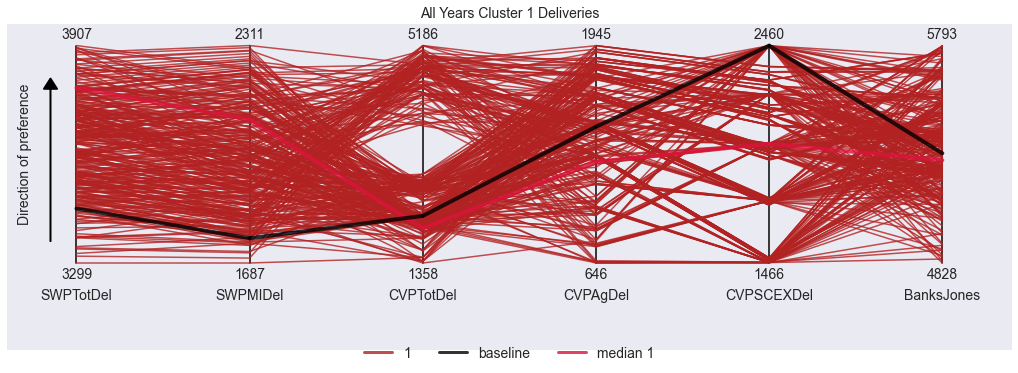

In [239]:
custom_parallel_coordinates_highlight_cluster(df_716_g1_1, columns_axes=df_716_g1_1.columns,
                                              axis_labels = df_716_g1_1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
                                              save_fig_filename = f'{fig_dir}/df_all_cluster1_deliveries.png', title="All Years Cluster 1 Deliveries",
                                              highlight_indices = [all_medoids[0]], highlight_colors = [median_colors[0]])

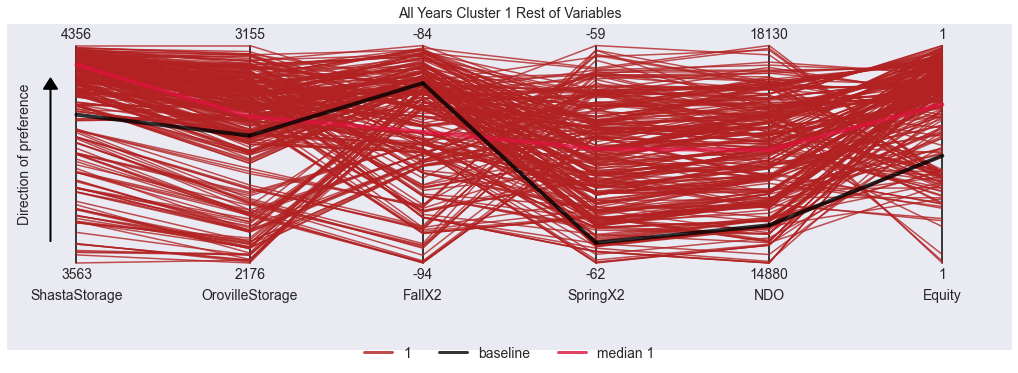

In [240]:
custom_parallel_coordinates_highlight_cluster(df_716_g2_1, columns_axes=df_716_g2_1.columns,
                                              axis_labels = df_716_g2_1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
                                              save_fig_filename = f'{fig_dir}/df_all_cluster1_rest.png', title="All Years Cluster 1 Rest of Variables", 
                                              highlight_indices = [all_medoids[0]], highlight_colors = [median_colors[0]])

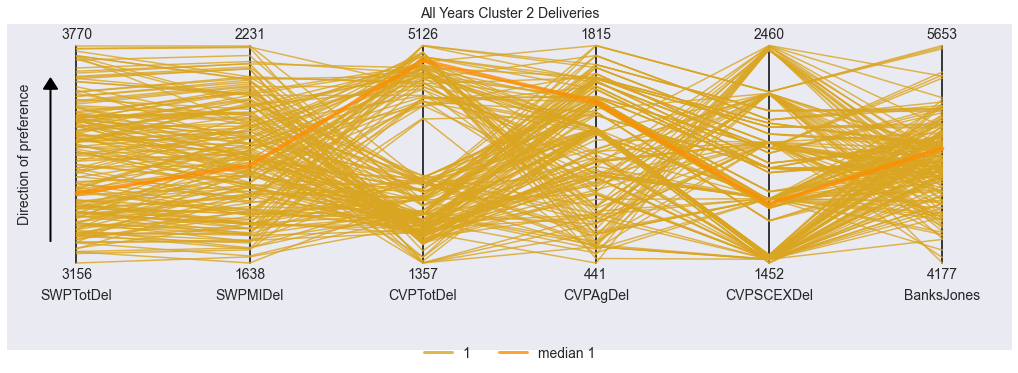

In [241]:
custom_parallel_coordinates_highlight_cluster(df_716_g1_2, columns_axes=df_716_g1_2.columns,
                                              axis_labels = df_716_g1_2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
                                              save_fig_filename = f'{fig_dir}/df_all_cluster2_deliveries.png', title="All Years Cluster 2 Deliveries", 
                                              highlight_indices = [all_medoids[1]], highlight_colors = [median_colors[1]])

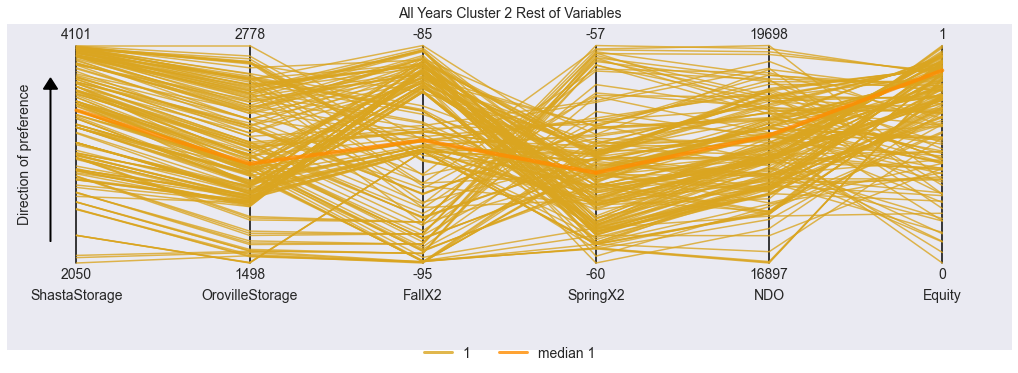

In [242]:
custom_parallel_coordinates_highlight_cluster(df_716_g2_2, columns_axes=df_716_g2_2.columns,
                                              axis_labels = df_716_g2_2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
                                              save_fig_filename = f'{fig_dir}/df_all_cluster2_rest.png', title="All Years Cluster 2 Rest of Variables", 
                                              highlight_indices = [all_medoids[1]], highlight_colors = [median_colors[1]])

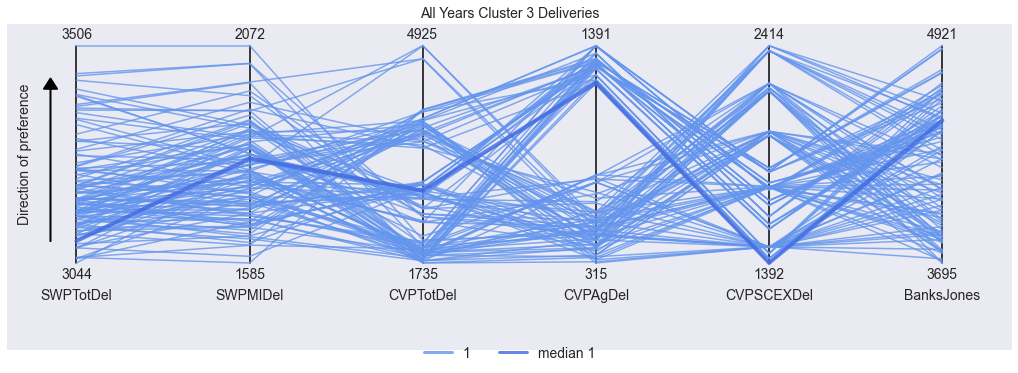

In [243]:
custom_parallel_coordinates_highlight_cluster(df_716_g1_3, columns_axes=df_716_g1_3.columns,
                                              axis_labels = df_716_g1_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename = f'{fig_dir}/df_all_cluster3_deliveries.png', title="All Years Cluster 3 Deliveries", 
                                              highlight_indices = [all_medoids[2]], highlight_colors = [median_colors[2]])

In [244]:
custom_parallel_coordinates_highlight_cluster(df_716_g2_3, columns_axes=df_716_g2_3.columns,
                                              axis_labels = df_716_g2_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename = f'{fig_dir}/df_all_cluster3_rest.png', title="All Years Cluster 3 Rest of Variables", 
                                              highlight_indices = [all_medoids[2]], highlight_colors = [median_colors[2]])

### Wet Years

In [246]:
custom_parallel_coordinates_highlight_cluster(wet_716_g1_1, columns_axes=wet_716_g1_1.columns,
                                              axis_labels = wet_716_g1_1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
                                              save_fig_filename = f'{fig_dir}/wet_all_cluster1_deliveries.png', title="Wet Years Cluster 1 Deliveries",
                                              highlight_indices = [wet_medoids[0]], highlight_colors = [median_colors[0]])

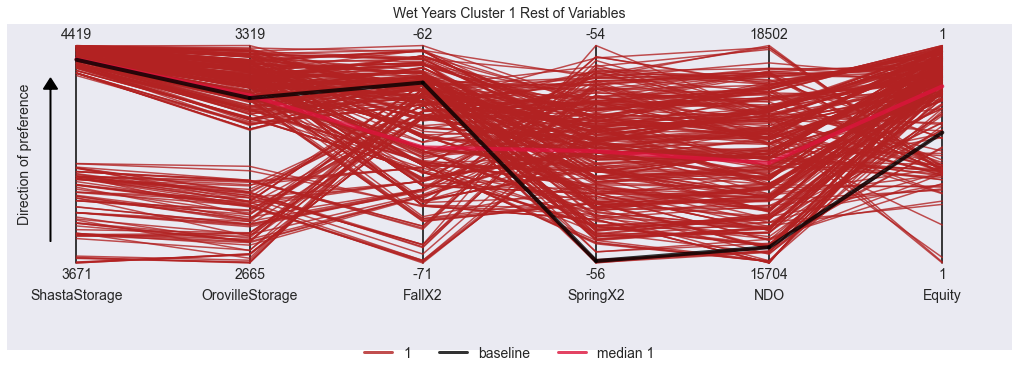

In [247]:
custom_parallel_coordinates_highlight_cluster(wet_716_g2_1, columns_axes=wet_716_g2_1.columns,
                                              axis_labels = wet_716_g2_1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
                                              save_fig_filename = f'{fig_dir}/wet_all_cluster1_rest.png', title="Wet Years Cluster 1 Rest of Variables", 
                                              highlight_indices = [wet_medoids[0]], highlight_colors = [median_colors[0]])

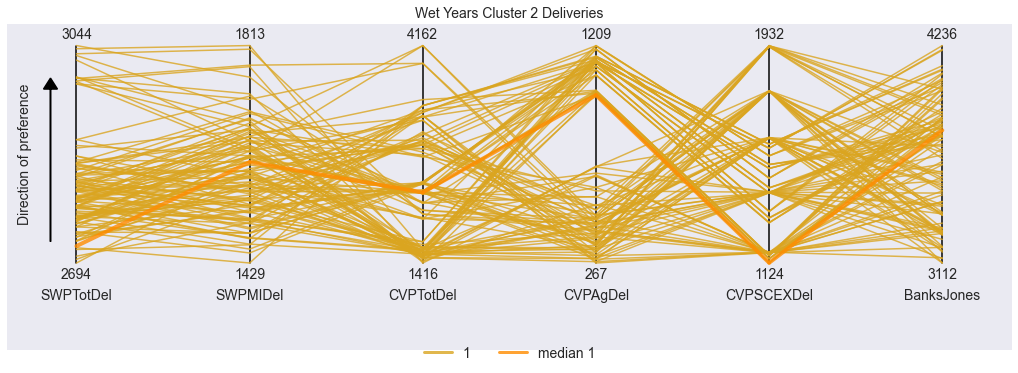

In [248]:
custom_parallel_coordinates_highlight_cluster(wet_716_g1_2, columns_axes=wet_716_g1_2.columns,
                                              axis_labels = wet_716_g1_2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
                                              save_fig_filename = f'{fig_dir}/wet_all_cluster2_deliveries.png', title="Wet Years Cluster 2 Deliveries", 
                                              highlight_indices = [wet_medoids[1]], highlight_colors = [median_colors[1]])

In [250]:
custom_parallel_coordinates_highlight_cluster(wet_716_g2_2, columns_axes=wet_716_g2_2.columns,
                                              axis_labels = wet_716_g2_2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
                                              save_fig_filename = f'{fig_dir}/wet_all_cluster2_rest.png', title="Wet Years Cluster 2 Rest of Variables",
                                              highlight_indices = [wet_medoids[1]], highlight_colors = [median_colors[1]])

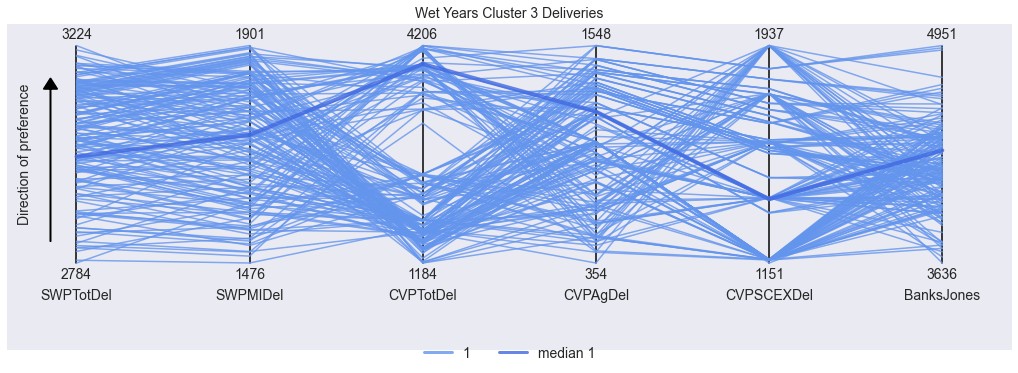

In [252]:
custom_parallel_coordinates_highlight_cluster(wet_716_g1_3, columns_axes=wet_716_g1_3.columns,
                                              axis_labels = wet_716_g1_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename = f'{fig_dir}/wet_all_cluster3_deliveries.png', title="Wet Years Cluster 3 Deliveries",
                                              highlight_indices = [wet_medoids[2]], highlight_colors = [median_colors[2]])

In [253]:
custom_parallel_coordinates_highlight_cluster(wet_716_g2_3, columns_axes=wet_716_g2_3.columns,
                                              axis_labels = wet_716_g2_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename = f'{fig_dir}/wet_all_cluster3_rest.png', title="Wet Years Cluster 3 Rest of Variables", 
                                              highlight_indices = [wet_medoids[2]], highlight_colors = [median_colors[2]])

### Dry Years

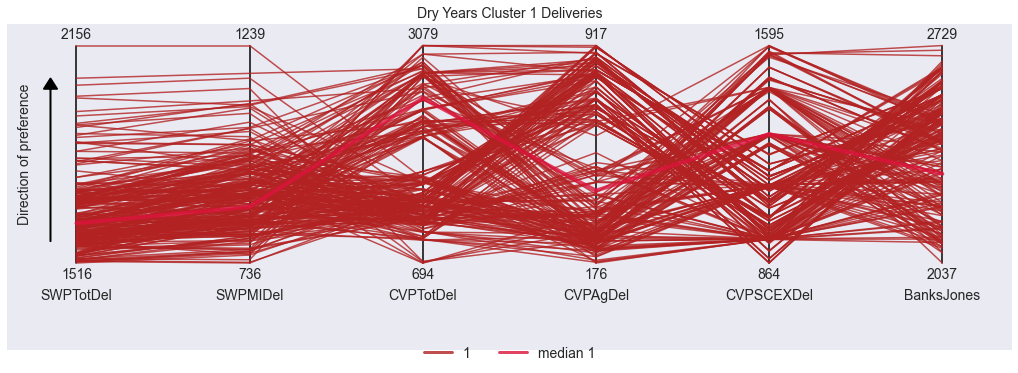

In [254]:
custom_parallel_coordinates_highlight_cluster(dry_716_g1_1, columns_axes=dry_716_g1_1.columns,
                                              axis_labels = dry_716_g1_1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
                                              save_fig_filename = f'{fig_dir}/dry_all_cluster1_deliveries.png', title="Dry Years Cluster 1 Deliveries",
                                              highlight_indices = [dry_medoids[0]], highlight_colors = [median_colors[0]])

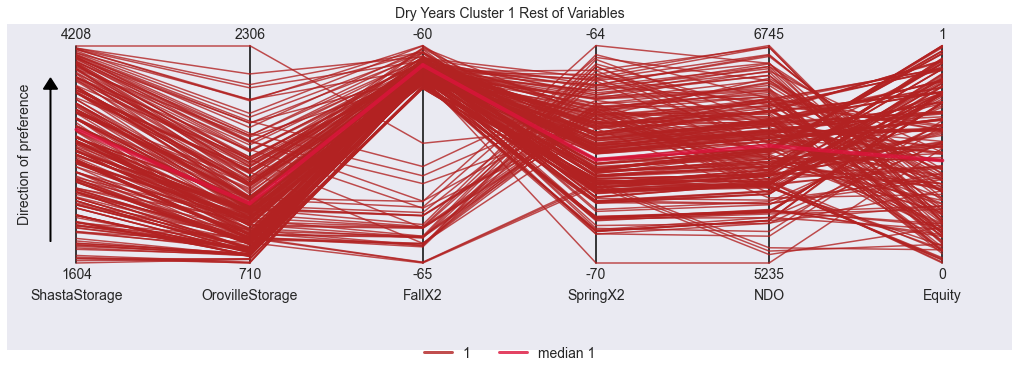

In [255]:
custom_parallel_coordinates_highlight_cluster(dry_716_g2_1, columns_axes=dry_716_g2_1.columns,
                                              axis_labels = dry_716_g2_1.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_1,
                                              save_fig_filename = f'{fig_dir}/dry_all_cluster1_rest.png', title="Dry Years Cluster 1 Rest of Variables",
                                              highlight_indices = [dry_medoids[0]], highlight_colors = [median_colors[0]])

In [256]:
custom_parallel_coordinates_highlight_cluster(dry_716_g1_2, columns_axes=dry_716_g1_2.columns,
                                              axis_labels = dry_716_g1_2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
                                              save_fig_filename = f'{fig_dir}/dry_all_cluster2_deliveries.png', title="Dry Years Cluster 2 Deliveries",
                                              highlight_indices = [dry_medoids[1]], highlight_colors = [median_colors[1]])

In [257]:
custom_parallel_coordinates_highlight_cluster(dry_716_g2_2, columns_axes=dry_716_g2_2.columns,
                                              axis_labels = dry_716_g2_2.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_2,
                                              save_fig_filename = f'{fig_dir}/dry_all_cluster2_rest.png', title="Dry Years Cluster 2 Rest of Variables", 
                                              highlight_indices = [dry_medoids[1]], highlight_colors = [median_colors[1]])

In [258]:
custom_parallel_coordinates_highlight_cluster(dry_716_g1_3, columns_axes=dry_716_g1_3.columns,
                                              axis_labels = dry_716_g1_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename = f'{fig_dir}/dry_all_cluster3_deliveries.png', title="Dry Years Cluster 3 Deliveries",
                                              highlight_indices = [dry_medoids[2]], highlight_colors = [median_colors[2]])

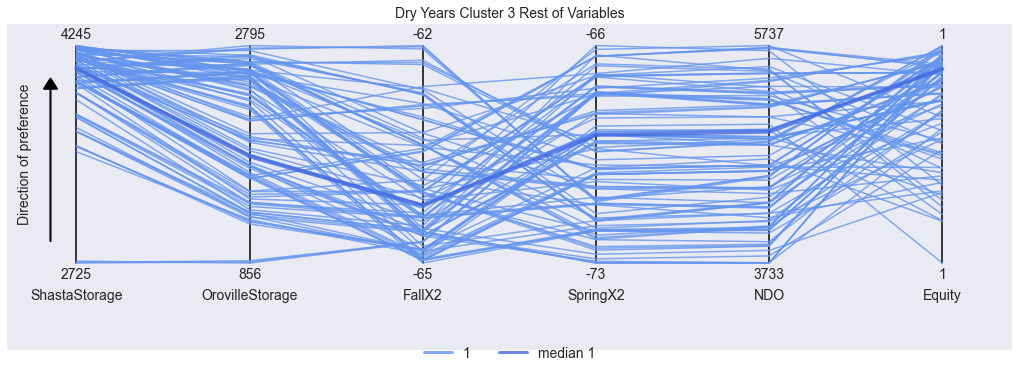

In [259]:
custom_parallel_coordinates_highlight_cluster(dry_716_g2_3, columns_axes=dry_716_g2_3.columns,
                                              axis_labels = dry_716_g2_3.columns,
                                              zorder_by=4, ideal_direction='top',
                                              alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                                              minmaxs=['max','max','max','max','max', 'max', 'max'],
                                              color_by_categorical = 'Cluster', color_dict_categorical=color_dict_categorical_3,
                                              save_fig_filename = f'{fig_dir}/dry_all_cluster3_rest.png', title="Dry Years Cluster 3 Rest of Variables",
                                              highlight_indices = [dry_medoids[2]], highlight_colors = [median_colors[2]])